#### Previsão da concentração de poluentes atmosféricos

- Treinar modelos usando os recursos gerados em feature_engineering.ipynb
- Prever a concentração de CO na próxima hora.
- Comparar o desempenho de uma previsão ingênua, com florestas aleatórias e regressão linear.

In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error

In [49]:
data = pd.read_csv(
    "../datasets/air_quality_preprocessed.csv",
    parse_dates=["date_time"],
    index_col=["date_time"],
)

data.head()

,co_sensor,month,week,day,day_of_week,hour,is_weekend,co_sensor_lag_1,rh_lag_1,co_sensor_lag_24,rh_lag_24,co_sensor_window,rh_window,month_sin,month_cos,hour_sin,hour_cos
date_time,,,,,,,,,,,,,,,,,
2004-04-02 00:00:00,1139.0,4,14,2,4,0,0,1203.0,52.0,1143.0,61.6,1193.666667,48.000000,0.866025,-0.5,0.000000,1.000000
2004-04-02 01:00:00,1072.0,4,14,2,4,1,0,1139.0,54.4,1044.0,63.9,1176.000000,51.466667,0.866025,-0.5,0.269797,0.962917
2004-04-02 02:00:00,954.0,4,14,2,4,2,0,1072.0,58.8,1034.0,67.2,1138.000000,55.066667,0.866025,-0.5,0.519584,0.854419
2004-04-02 03:00:00,951.0,4,14,2,4,3,0,954.0,60.9,956.0,73.1,1055.000000,58.033333,0.866025,-0.5,0.730836,0.682553
2004-04-02 04:00:00,926.0,4,14,2,4,4,0,951.0,64.3,909.0,66.6,992.333333,61.333333,0.866025,-0.5,0.887885,0.460065


In [50]:
data.index.min(), data.index.max()

(Timestamp('2004-04-02 00:00:00'), Timestamp('2005-04-04 14:00:00'))

In [51]:
# Separar os dados de treino e teste (ultimo mes para teste)

X_train = data[data.index <= "2005-03-04"]
X_test = data[data.index > "2005-03-04"]

X_train.shape, X_test.shape

((7496, 17), (755, 17))

In [52]:
# Separar a variavel alvo dos dados de treino e teste
y_train = X_train["co_sensor"].copy()
y_test = X_test["co_sensor"].copy()

# Remover a variavel alvo dos dados de treino e teste
X_train = X_train.drop("co_sensor", axis=1)
X_test = X_test.drop("co_sensor", axis=1)

print("=" * 60)
X_train.head()

,month,week,day,day_of_week,hour,is_weekend,co_sensor_lag_1,rh_lag_1,co_sensor_lag_24,rh_lag_24,co_sensor_window,rh_window,month_sin,month_cos,hour_sin,hour_cos
date_time,,,,,,,,,,,,,,,,
2004-04-02 00:00:00,4,14,2,4,0,0,1203.0,52.0,1143.0,61.6,1193.666667,48.000000,0.866025,-0.5,0.000000,1.000000
2004-04-02 01:00:00,4,14,2,4,1,0,1139.0,54.4,1044.0,63.9,1176.000000,51.466667,0.866025,-0.5,0.269797,0.962917
2004-04-02 02:00:00,4,14,2,4,2,0,1072.0,58.8,1034.0,67.2,1138.000000,55.066667,0.866025,-0.5,0.519584,0.854419
2004-04-02 03:00:00,4,14,2,4,3,0,954.0,60.9,956.0,73.1,1055.000000,58.033333,0.866025,-0.5,0.730836,0.682553
2004-04-02 04:00:00,4,14,2,4,4,0,951.0,64.3,909.0,66.6,992.333333,61.333333,0.866025,-0.5,0.887885,0.460065


#### Previsão Ingênua

- Prever a concentração do poluente no tempo t com o seu valor no tempo t-1 (co_sensor_lag_1).
- Prever a concentração do poluente no tempo t com a média dos valores anteriores (co_sensor_window).

In [53]:
print("train rmse t - 1 : ", mean_squared_error(y_train, X_train["co_sensor_lag_1"], squared=False,))
print("test rmse t - 1  : ",  mean_squared_error(y_test, X_test["co_sensor_lag_1"], squared=False,))

print("train rmse window: ", mean_squared_error(y_train, X_train["co_sensor_window"], squared=False,))
print("test rmse window : ",  mean_squared_error(y_test, X_test["co_sensor_window"], squared=False,))

train rmse t - 1 :  101.54241047923686
test rmse t - 1  :  104.08288851736968
train rmse window:  141.23582617102932
test rmse window :  146.51224072200716


In [60]:
# Performance of random forests

rf_model = RandomForestRegressor(
    n_estimators=50,
    max_depth=3,
    random_state=0,
)

rf_model.fit(X_train, y_train)


RandomForestRegressor(max_depth=3, n_estimators=50, random_state=0)

In [61]:
rf_pred_train = rf_model.predict(X_train)
rf_pred_test = rf_model.predict(X_test)

print("train rmse: ", mean_squared_error(y_train, rf_pred_train, squared=False,))
print("test rmse: ",  mean_squared_error(y_test, rf_pred_test, squared=False,))

# Pequeno aumento em relação à Previsão Ingênua. As previsões feitas pelas Random Forests retornam valores menores.

train rmse:  99.11640791998293
test rmse:  101.81080323668142


#### Regressão linear

Os modelos de regressão Random Forest não são muito bons em extrapolar valores além daqueles observados nos dados. Então, vamos agora treinar uma regressão Lasso para comparação.

In [58]:
linear_model = Lasso(alpha=100, random_state=0)
linear_model.fit(X_train, y_train)


train rmse:  90.78249429064532
test rmse:  88.84638170444882


In [62]:
linear_pred_train = linear_model.predict(X_train)
linear_pred_test = linear_model.predict(X_test)

print("train rmse: ", mean_squared_error(y_train, linear_pred_train, squared=False,))
print("test rmse: ",  mean_squared_error(y_test, linear_pred_test, squared=False,))

train rmse:  90.78249429064532
test rmse:  88.84638170444882


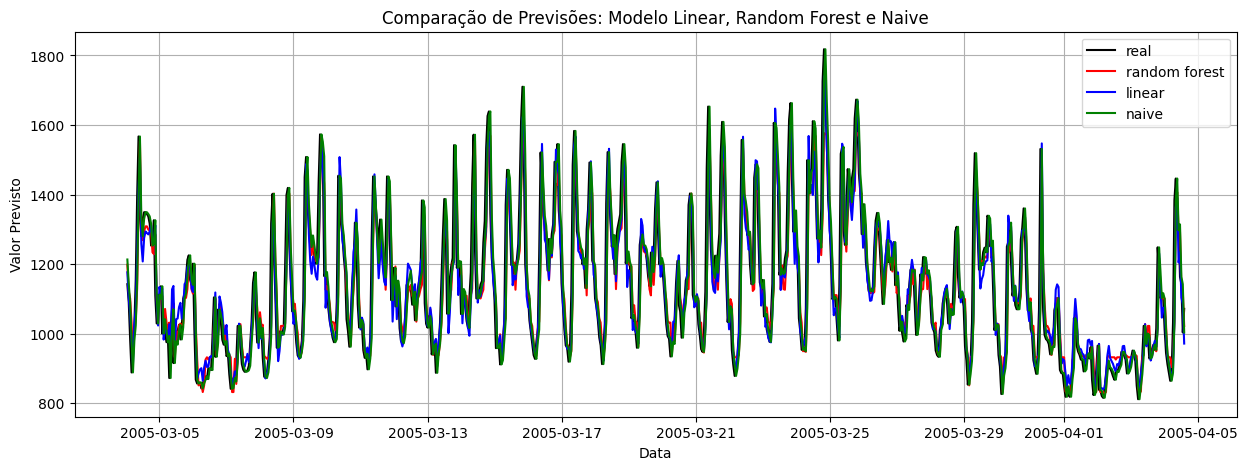

In [70]:
# grafico de previsão linear model, random forest, naive e real

plt.figure(figsize=(15, 5))

plt.title("Comparação de Previsões: Modelo Linear, Random Forest e Naive")
plt.xlabel("Data")
plt.ylabel("Valor Previsto")

plt.plot(y_test.index, y_test.values, label="real", color="black")
plt.plot(y_test.index, rf_pred_test, label="random forest", color="red")
plt.plot(y_test.index, linear_pred_test, label="linear", color="blue")
plt.plot(y_test.index, X_test["co_sensor_lag_1"], label="naive", color="green")

plt.legend()
plt.grid(True)
plt.show()

AttributeError: Text.set() got an unexpected keyword argument 'linestyle'

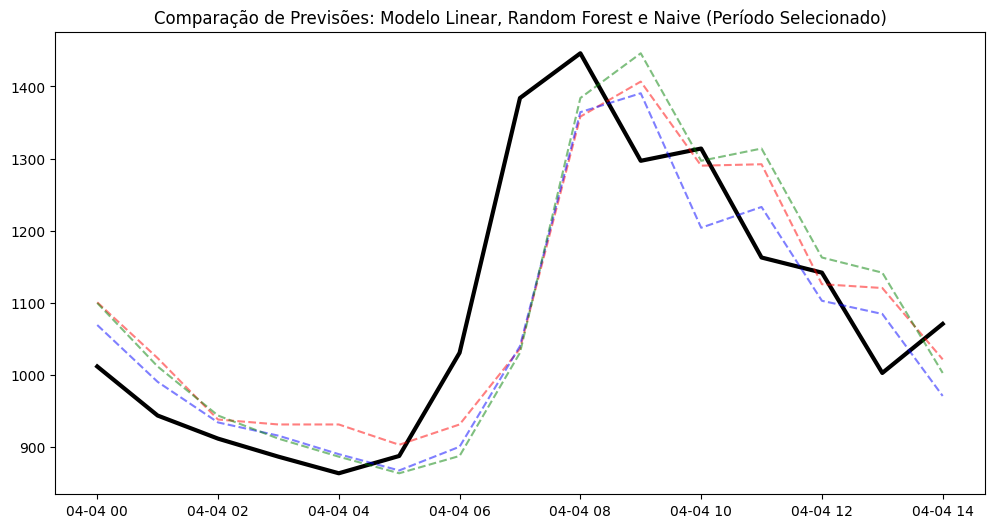

In [73]:
start_date = '2005-04-04 00:00:00'
end_date = '2005-04-04 23:59:59'

subset = (y_test.index >= start_date) & (y_test.index <= end_date)
y_test_subset = y_test[subset]
rf_pred_test_subset = rf_pred_test[subset]
linear_pred_test_subset = linear_pred_test[subset]
naive_data_subset = X_test["co_sensor_lag_1"][subset]

plt.figure(figsize=(12, 6))

plt.plot(y_test_subset.index, y_test_subset.values, label="Real", color="black", linewidth=3)
plt.plot(y_test_subset.index, rf_pred_test_subset, label="Random Forest", color="red", linestyle="--", alpha=0.5)
plt.plot(y_test_subset.index, linear_pred_test_subset, label="Linear Model", color="blue", linestyle="--", alpha=0.5)
plt.plot(y_test_subset.index, naive_data_subset, label="Naive", color="green", linestyle="--", alpha=0.5)

plt.title("Comparação de Previsões: Modelo Linear, Random Forest e Naive (Período Selecionado)")
plt.xlabel("Data")
plt.ylabel("Valor Previsto")

plt.legend()

plt.grid(True)
plt.show()


Text(0, 0.5, 'Importance')

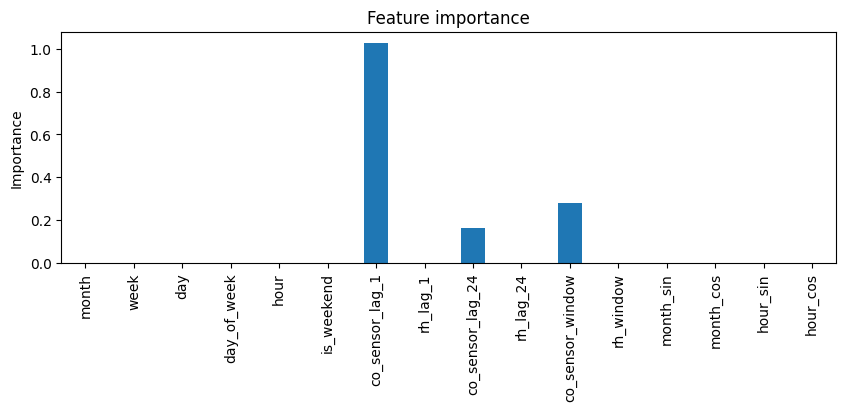

In [56]:
# Let's now plot the feature's importance
# according to the linear model.

# Create series with feature importance.
tmp = pd.Series(np.abs(linear_model.coef_))

# Let's add the variable names.
tmp.index = X_train.columns

# Let's make a bar plot.
tmp.plot.bar(figsize=(10, 3), title="Feature importance linear model")
plt.title("Feature importance")
plt.ylabel("Importance")

In [57]:
# A característica mais importante é a concentração de CO na hora anterior. 
# Porém, a umidade na hora anterior também contribui para a concentração de CO, 
# assim como a hora do dia (CO_sensor_season) e a concentração de CO no dia 
# anterior e nas 3 horas anteriores.